In [8]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs  
from matplotlib import ticker, cm

import aeolus

from aeolus.calc.stats import cumsum, spatial
from aeolus.const import init_const
from aeolus.coord import roll_cube_pm180, volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels

pcb_const=init_const('proxb')


In [2]:
warnings.filterwarnings("ignore")


# Load the data: ask for availability of dataset and change to local directories

In [3]:
pcb_11 = iris.load('../../eccent//data/pcb_synch_8040_600.nc')
pcb_32 = iris.load('../data/pcb_32_fix_17120_120.nc')

ut_scale(): NULL factor argument
ut_raise(): NULL unit argument


# Functions to calculate hemispheric means and roll the cube coordinates

In [9]:
def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cuberoll_merid(cube_in):
    roll = roll_cube_pm180(cube_in)
    #roll_merid=meridional_mean(roll)
    return roll

In [ ]:
# Function <i>plot_lfr_distribs</i> plots the horizontal distributions of lightning flash rates for the 1:1 and 3:2 spib-orbit resonance. 

The maximum lightning flash rate is 3.2472185441292822 flashes km$^{-2}$ yr$^{-1}$
The maximum lightning flash rate is 11.050757858902216 flashes km$^{-2}$ yr$^{-1}$


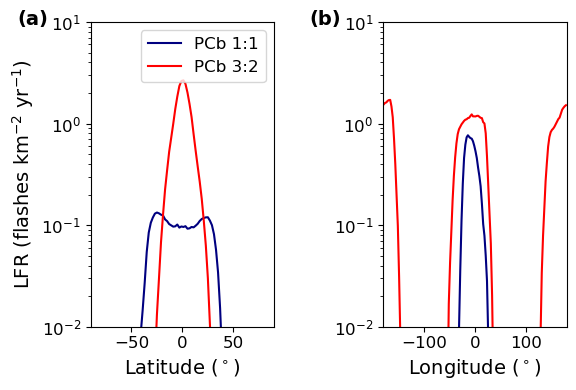

In [14]:

colors = ['navy', 'red']

def plot_lfr_distribs(cubes, time_slice_l=0, time_slice_u=-1, time_mean=False, save=False):
    lfr_list = []
    label_list = ['PCb 1:1', 'PCb 3:2', 'T1d 1:1', 'T1d 3:2']

    for cube in cubes:
        for cube_inner in cube:
            if cube_inner.long_name == 'Stash code = 21115':
                lfr = cube_inner[time_slice_l:time_slice_u,0,:,:].copy()
                lfr = lfr.collapsed('t', iris.analysis.MEAN)
                lfr_list.append(lfr)
    # Plotting ozone mixing ratios of all cubes in one plot
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(121)
    ax.text(-0.40,0.99, '(a)', size=14, weight='bold',transform=ax.transAxes)

    for i in range(len(lfr_list)):
        lfr_roll= cuberoll_merid(lfr_list[i])
        lfr_merid=zonal_mean(lfr_roll)
        lfr_zonal=meridional_mean(lfr_roll)
        max_lfr= np.max(lfr_roll.data)*8760
        print(r'The maximum lightning flash rate is %s flashes km$^{-2}$ yr$^{-1}$' %max_lfr)
        ax.plot(lfr_merid.coord('latitude').points, 8760*lfr_merid.data, label=label_list[i], color=colors[i])

#     ax.set_title(f'{species_name} Mixing Ratios', fontsize=15)
    ax.set_xlabel('Latitude ($^\circ$)', fontsize=14)
    ax.set_ylabel('LFR (flashes km$^{-2}$ yr$^{-1}$)', fontsize=14)
    ax.tick_params(labelsize=12)
    ax.legend(loc='best', fontsize=12)
    ax.set_yscale('log')
    ax.set_xlim(-90,90)
    ax.set_ylim(1e-2,1e1)
    plt.tight_layout()
    ax = fig.add_subplot(122)
    ax.text(-0.40,0.99, '(b)', size=14, weight='bold',transform=ax.transAxes)
    for i in range(len(lfr_list)):

        lfr_roll= cuberoll_merid(lfr_list[i])
        lfr_merid=zonal_mean(lfr_roll)
        lfr_zonal=meridional_mean(lfr_roll)
        ax.plot(lfr_zonal.coord('longitude').points, 8760*lfr_zonal.data, label=label_list[i], color=colors[i])

#     ax.set_title(f'{species_name} Mixing Ratios', fontsize=15)
    ax.set_xlabel('Longitude ($^\circ$)', fontsize=14)
    #ax.set_ylabel('LFR (flashes km$^{-2}$ yr$^{-1}$)', fontsize=14)
    ax.tick_params(labelsize=12)
    #ax.legend(loc='best', fontsize=12)
    ax.set_yscale('log')
    ax.set_xlim(-180,180)
    ax.set_ylim(1e-2,1e1)
    plt.tight_layout()
    if save==True:
        plt.savefig('LFR_comp.pdf', bbox_inches='tight')
    plt.show()
# Example usage with multiple cubes and species name
plot_lfr_distribs(cubes=[pcb_11, pcb_32],  time_mean=True, save=False)
